In [5]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
def load_dataset():
    train_dataset = h5py.File("datasets/train_catvnoncat.h5", "r")
    train_set_x_orig = np.array(
        train_dataset["train_set_x"][:]
    )  # your train set features
    train_set_y_orig = np.array(
        train_dataset["train_set_y"][:]
    )  # your train set labels

    test_dataset = h5py.File("datasets/test_catvnoncat.h5", "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [7]:
def sigmoid_test(target):
    x = np.array([0, 2])
    output = target(x)
    assert type(output) == np.ndarray, "Wrong type. Expected np.ndarray"
    assert np.allclose(
        output, [0.5, 0.88079708]
    ), f"Wrong value. {output} != [0.5, 0.88079708]"
    output = target(1)
    assert np.allclose(output, 0.7310585), f"Wrong value. {output} != 0.7310585"
    print("\033[92mAll tests passed!")


def initialize_with_zeros_test_1(target):
    dim = 3
    w, b = target(dim)
    assert type(b) == float, f"Wrong type for b. {type(b)} != float"
    assert b == 0.0, "b must be 0.0"
    assert type(w) == np.ndarray, f"Wrong type for w. {type(w)} != np.ndarray"
    assert w.shape == (dim, 1), f"Wrong shape for w. {w.shape} != {(dim, 1)}"
    assert np.allclose(
        w, [[0.0], [0.0], [0.0]]
    ), f"Wrong values for w. {w} != {[[0.], [0.], [0.]]}"
    print("\033[92mFirst test passed!")


def initialize_with_zeros_test_2(target):
    dim = 4
    w, b = target(dim)
    assert type(b) == float, f"Wrong type for b. {type(b)} != float"
    assert b == 0.0, "b must be 0.0"
    assert type(w) == np.ndarray, f"Wrong type for w. {type(w)} != np.ndarray"
    assert w.shape == (dim, 1), f"Wrong shape for w. {w.shape} != {(dim, 1)}"
    assert np.allclose(
        w, [[0.0], [0.0], [0.0], [0.0]]
    ), f"Wrong values for w. {w} != {[[0.], [0.], [0.], [0.]]}"
    print("\033[92mSecond test passed!")


def propagate_test(target):
    w, b = (
        np.array([[1.0], [2.0], [-1]]),
        2.5,
    )
    X = np.array([[1.0, 2.0, -1.0, 0], [3.0, 4.0, -3.2, 1], [3.0, 4.0, -3.2, -3.5]])
    Y = np.array([[1, 1, 0, 0]])

    expected_dw = np.array([[-0.03909333], [0.12501464], [-0.99960809]])
    expected_db = np.float64(0.288106326429569)
    expected_grads = {"dw": expected_dw, "db": expected_db}
    expected_cost = np.array(2.0424567983978403)
    expected_output = (expected_grads, expected_cost)

    grads, cost = target(w, b, X, Y)

    assert (
        type(grads["dw"]) == np.ndarray
    ), f"Wrong type for grads['dw']. {type(grads['dw'])} != np.ndarray"
    assert (
        grads["dw"].shape == w.shape
    ), f"Wrong shape for grads['dw']. {grads['dw'].shape} != {w.shape}"
    assert np.allclose(
        grads["dw"], expected_dw
    ), f"Wrong values for grads['dw']. {grads['dw']} != {expected_dw}"
    assert np.allclose(
        grads["db"], expected_db
    ), f"Wrong values for grads['db']. {grads['db']} != {expected_db}"
    assert np.allclose(
        cost, expected_cost
    ), f"Wrong values for cost. {cost} != {expected_cost}"
    print("\033[92mAll tests passed!")


def optimize_test(target):
    w, b, X, Y = (
        np.array([[1.0], [2.0]]),
        2.0,
        np.array([[1.0, 2.0, -1.0], [3.0, 4.0, -3.2]]),
        np.array([[1, 0, 1]]),
    )
    expected_w = np.array([[-0.70916784], [-0.42390859]])
    expected_b = np.float64(2.26891346)
    expected_params = {"w": expected_w, "b": expected_b}

    expected_dw = np.array([[0.06188603], [-0.01407361]])
    expected_db = np.float64(-0.04709353)
    expected_grads = {"dw": expected_dw, "db": expected_db}

    expected_cost = [5.80154532, 0.31057104]
    expected_output = (expected_params, expected_grads, expected_cost)

    params, grads, costs = target(
        w, b, X, Y, num_iterations=101, learning_rate=0.1, print_cost=False
    )

    assert type(costs) == list, "Wrong type for costs. It must be a list"
    assert len(costs) == 2, f"Wrong length for costs. {len(costs)} != 2"
    assert np.allclose(
        costs, expected_cost
    ), f"Wrong values for costs. {costs} != {expected_cost}"

    assert (
        type(grads["dw"]) == np.ndarray
    ), f"Wrong type for grads['dw']. {type(grads['dw'])} != np.ndarray"
    assert (
        grads["dw"].shape == w.shape
    ), f"Wrong shape for grads['dw']. {grads['dw'].shape} != {w.shape}"
    assert np.allclose(
        grads["dw"], expected_dw
    ), f"Wrong values for grads['dw']. {grads['dw']} != {expected_dw}"

    assert np.allclose(
        grads["db"], expected_db
    ), f"Wrong values for grads['db']. {grads['db']} != {expected_db}"

    assert (
        type(params["w"]) == np.ndarray
    ), f"Wrong type for params['w']. {type(params['w'])} != np.ndarray"
    assert (
        params["w"].shape == w.shape
    ), f"Wrong shape for params['w']. {params['w'].shape} != {w.shape}"
    assert np.allclose(
        params["w"], expected_w
    ), f"Wrong values for params['w']. {params['w']} != {expected_w}"

    assert np.allclose(
        params["b"], expected_b
    ), f"Wrong values for params['b']. {params['b']} != {expected_b}"

    print("\033[92mAll tests passed!")


def predict_test(target):
    w = np.array([[0.3], [0.5], [-0.2]])
    b = -0.33333
    X = np.array([[1.0, -0.3, 1.5], [2, 0, 1], [0, -1.5, 2]])

    pred = target(w, b, X)

    assert type(pred) == np.ndarray, f"Wrong type for pred. {type(pred)} != np.ndarray"
    assert pred.shape == (
        1,
        X.shape[1],
    ), f"Wrong shape for pred. {pred.shape} != {(1, X.shape[1])}"
    assert np.bitwise_not(
        np.allclose(pred, [[1.0, 1.0, 1]])
    ), f"Perhaps you forget to add b in the calculation of A"
    assert np.allclose(
        pred, [[1.0, 0.0, 1]]
    ), f"Wrong values for pred. {pred} != {[[1., 0., 1.]]}"

    print("\033[92mAll tests passed!")


def model_test(target):
    np.random.seed(0)

    expected_output = {
        "costs": [np.array(0.69314718)],
        "Y_prediction_test": np.array([[1.0, 1.0, 0.0]]),
        "Y_prediction_train": np.array([[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]]),
        "w": np.array([[0.08639757], [-0.08231268], [-0.11798927], [0.12866053]]),
        "b": -0.03983236094816321,
    }

    # Use 3 samples for training
    b, Y, X = (
        1.5,
        np.array([1, 0, 0, 1, 0, 0, 1]).reshape(1, 7),
        np.random.randn(4, 7),
    )

    # Use 6 samples for testing
    x_test = np.random.randn(4, 3)
    y_test = np.array([0, 1, 0])

    d = target(X, Y, x_test, y_test, num_iterations=50, learning_rate=0.01)

    assert (
        type(d["costs"]) == list
    ), f"Wrong type for d['costs']. {type(d['costs'])} != list"
    assert len(d["costs"]) == 1, f"Wrong length for d['costs']. {len(d['costs'])} != 1"
    assert np.allclose(
        d["costs"], expected_output["costs"]
    ), f"Wrong values for d['costs']. {d['costs']} != {expected_output['costs']}"

    assert (
        type(d["w"]) == np.ndarray
    ), f"Wrong type for d['w']. {type(d['w'])} != np.ndarray"
    assert d["w"].shape == (
        X.shape[0],
        1,
    ), f"Wrong shape for d['w']. {d['w'].shape} != {(X.shape[0], 1)}"
    assert np.allclose(
        d["w"], expected_output["w"]
    ), f"Wrong values for d['w']. {d['w']} != {expected_output['w']}"

    assert np.allclose(
        d["b"], expected_output["b"]
    ), f"Wrong values for d['b']. {d['b']} != {expected_output['b']}"

    assert (
        type(d["Y_prediction_test"]) == np.ndarray
    ), f"Wrong type for d['Y_prediction_test']. {type(d['Y_prediction_test'])} != np.ndarray"
    assert d["Y_prediction_test"].shape == (
        1,
        x_test.shape[1],
    ), f"Wrong shape for d['Y_prediction_test']. {d['Y_prediction_test'].shape} != {(1, x_test.shape[1])}"
    assert np.allclose(
        d["Y_prediction_test"], expected_output["Y_prediction_test"]
    ), f"Wrong values for d['Y_prediction_test']. {d['Y_prediction_test']} != {expected_output['Y_prediction_test']}"

    assert (
        type(d["Y_prediction_train"]) == np.ndarray
    ), f"Wrong type for d['Y_prediction_train']. {type(d['Y_prediction_train'])} != np.ndarray"
    assert d["Y_prediction_train"].shape == (
        1,
        X.shape[1],
    ), f"Wrong shape for d['Y_prediction_train']. {d['Y_prediction_train'].shape} != {(1, X.shape[1])}"
    assert np.allclose(
        d["Y_prediction_train"], expected_output["Y_prediction_train"]
    ), f"Wrong values for d['Y_prediction_train']. {d['Y_prediction_train']} != {expected_output['Y_prediction_train']}"

    print("\033[92mAll tests passed!")

Problem Statement: 
Given dataset ("data.h5") containing
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

Build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

In [15]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
train_set_x_orig.shape

(209, 64, 64, 3)

y = [0], it's a 'non-cat' picture.


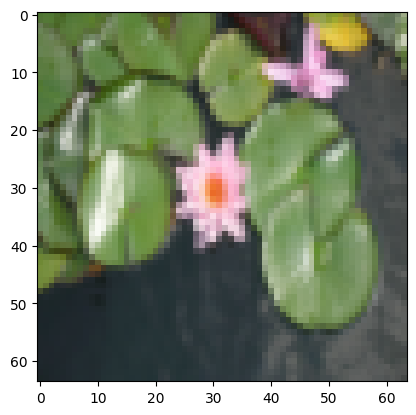

In [18]:
i = 26
plt.imshow(train_set_x_orig[i])
print(
    "y = "
    + str(train_set_y[:, i])
    + ", it's a '"
    + classes[np.squeeze(train_set_y[:, i])].decode("utf-8")
    + "' picture."
)

In [22]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape: " + str(test_set_x_orig.shape))
print("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [32]:
# images of size (num_px, num_px, 3) are flattened into single vectors of shape
# (num_px * num_px * 3, 1)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
# test_set_x_flatten = ...
print(train_set_x_flatten.shape)
# assert np.alltrue(
#     train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]
# ), "Wrong solution. Use (X.shape[0], -1).T."
# assert np.alltrue(
#     test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]
# ), "Wrong solution. Use (X.shape[0], -1).T."

print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("train_set_y shape: " + str(train_set_y.shape))
# print("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print("test_set_y shape: " + str(test_set_y.shape))

(12288, 209)
train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_y shape: (1, 50)
